In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os.path
import re
import sys
import tarfile

import numpy as np
from six.moves import urllib
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
FLAGS = None

class NodeLookup(object):
  """Converts integer node ID's to human readable labels."""

  def __init__(self,
               label_lookup_path=None,
               uid_lookup_path=None):
    if not label_lookup_path:
      label_lookup_path = os.path.join(
          FLAGS.model_dir, 'imagenet_2012_challenge_label_map_proto.pbtxt')
    if not uid_lookup_path:
      uid_lookup_path = os.path.join(
          FLAGS.model_dir, 'imagenet_synset_to_human_label_map.txt')
    self.node_lookup = self.load(label_lookup_path, uid_lookup_path)

  def load(self, label_lookup_path, uid_lookup_path):
    """Loads a human readable English name for each softmax node.
    Args:
      label_lookup_path: string UID to integer node ID.
      uid_lookup_path: string UID to human-readable string.
    Returns:
      dict from integer node ID to human-readable string.
    """
    if not tf.gfile.Exists(uid_lookup_path):
      tf.logging.fatal('File does not exist %s', uid_lookup_path)
    if not tf.gfile.Exists(label_lookup_path):
      tf.logging.fatal('File does not exist %s', label_lookup_path)

    # Loads mapping from string UID to human-readable string
    proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
    uid_to_human = {}
    p = re.compile(r'[n\d]*[ \S,]*')
    for line in proto_as_ascii_lines:
      parsed_items = p.findall(line)
      uid = parsed_items[0]
      human_string = parsed_items[2]
      uid_to_human[uid] = human_string

    # Loads mapping from string UID to integer node ID.
    node_id_to_uid = {}
    proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
    for line in proto_as_ascii:
      if line.startswith('  target_class:'):
        target_class = int(line.split(': ')[1])
      if line.startswith('  target_class_string:'):
        target_class_string = line.split(': ')[1]
        node_id_to_uid[target_class] = target_class_string[1:-2]

    # Loads the final mapping of integer node ID to human-readable string
    node_id_to_name = {}
    for key, val in node_id_to_uid.items():
      if val not in uid_to_human:
        tf.logging.fatal('Failed to locate: %s', val)
      name = uid_to_human[val]
      node_id_to_name[key] = name

    return node_id_to_name

  def id_to_string(self, node_id):
    if node_id not in self.node_lookup:
      return ''
    return self.node_lookup[node_id]

In [3]:
def create_graph():
  """Creates a graph from saved GraphDef file and returns a saver."""
  # Creates graph from saved graph_def.pb.
  with tf.gfile.FastGFile(os.path.join(
      FLAGS.model_dir, 'classify_image_graph_def.pb'), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')

In [4]:
def run_inference_on_image(image):
  """Runs inference on an image.
  Args:
    image: Image file name.
  Returns:
    Nothing
  """
  if not tf.gfile.Exists(image):
    tf.logging.fatal('File does not exist %s', image)
  image_data = tf.gfile.FastGFile(image, 'rb').read()

  # Creates graph from saved GraphDef.
  create_graph()

  with tf.Session() as sess:
    # Some useful tensors:
    # 'softmax:0': A tensor containing the normalized prediction across
    #   1000 labels.
    # 'pool_3:0': A tensor containing the next-to-last layer containing 2048
    #   float description of the image.
    # 'DecodeJpeg/contents:0': A tensor containing a string providing JPEG
    #   encoding of the image.
    # Runs the softmax tensor by feeding the image_data as input to the graph.
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    predictions = sess.run(softmax_tensor,
                           {'DecodeJpeg/contents:0': image_data})
    predictions = np.squeeze(predictions)

    # Creates node ID --> English string lookup.
    node_lookup = NodeLookup()

    top_k = predictions.argsort()[-FLAGS.num_top_predictions:][::-1]
    for node_id in top_k:
      human_string = node_lookup.id_to_string(node_id)
      score = predictions[node_id]
      print('%s (score = %.5f)' % (human_string, score))

In [5]:
def main(img_dir):
  if isinstance(img_dir, list):
    print("")
    return
  image = (FLAGS.image_file if FLAGS.image_file else
           os.path.join(FLAGS.model_dir, img_dir))
  run_inference_on_image(image)


if __name__ == '__main__':
  parser = argparse.ArgumentParser()
  # classify_image_graph_def.pb:
  #   Binary representation of the GraphDef protocol buffer.
  # imagenet_synset_to_human_label_map.txt:
  #   Map from synset ID to a human readable string.
  # imagenet_2012_challenge_label_map_proto.pbtxt:
  #   Text representation of a protocol buffer mapping a label to synset ID.
  parser.add_argument(
      '--model_dir',
      type=str,
      default='./imagenet',
      help="""\
      Path to classify_image_graph_def.pb,
      imagenet_synset_to_human_label_map.txt, and
      imagenet_2012_challenge_label_map_proto.pbtxt.\
      """
  )
  parser.add_argument(
      '--image_file',
      type=str,
      default='',
      help='Absolute path to image file.'
  )
  parser.add_argument(
      '--num_top_predictions',
      type=int,
      default=5,
      help='Display this many predictions.'
  )
  FLAGS, unparsed = parser.parse_known_args()
  tf.app.run(main=main, argv=[sys.argv[0]] + unparsed)

SystemExit: 

//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [6]:
def make_inference(img_dir):
    img=mpimg.imread('./images/' + img_dir)
    plt.imshow(img)
    plt.show()
    img_dir = "../images/" + img_dir
    print("Making Inferences...")
    main(img_dir)

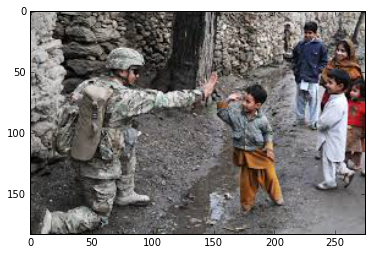

Making Inferences...
stone wall (score = 0.43520)
cliff, drop, drop-off (score = 0.31941)
megalith, megalithic structure (score = 0.04578)
military uniform (score = 0.03358)
stretcher (score = 0.02241)


In [7]:
make_inference("military.jpg")

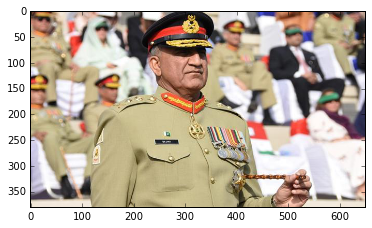

Making Inferences...
military uniform (score = 0.91621)
bearskin, busby, shako (score = 0.07646)
pickelhaube (score = 0.00038)
drumstick (score = 0.00032)
ballplayer, baseball player (score = 0.00027)


In [8]:
make_inference("sample.jpg")

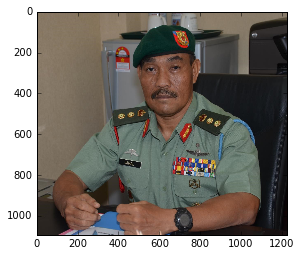

Making Inferences...
military uniform (score = 0.91475)
ambulance (score = 0.01289)
stretcher (score = 0.00809)
crash helmet (score = 0.00355)
Band Aid (score = 0.00292)


In [9]:
make_inference("kol.jpg")

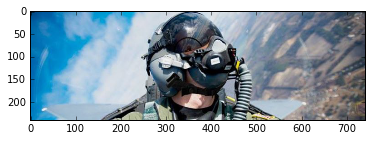

Making Inferences...
oxygen mask (score = 0.61206)
breastplate, aegis, egis (score = 0.18164)
cuirass (score = 0.07394)
scuba diver (score = 0.02527)
gasmask, respirator, gas helmet (score = 0.01908)


In [10]:
make_inference("air.jpg")

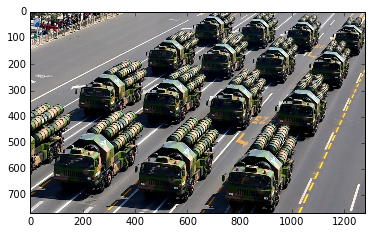

Making Inferences...
aircraft carrier, carrier, flattop, attack aircraft carrier (score = 0.11736)
spotlight, spot (score = 0.06200)
streetcar, tram, tramcar, trolley, trolley car (score = 0.04306)
cab, hack, taxi, taxicab (score = 0.03445)
pier (score = 0.03070)


In [11]:
make_inference("tanks.jpg")

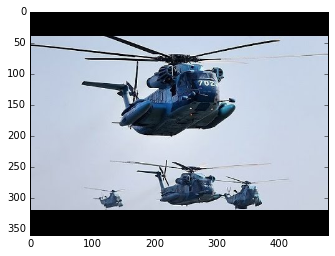

Making Inferences...
warplane, military plane (score = 0.71203)
wing (score = 0.02949)
aircraft carrier, carrier, flattop, attack aircraft carrier (score = 0.02891)
parachute, chute (score = 0.01268)
ambulance (score = 0.01104)


In [12]:
make_inference("heli.jpg")

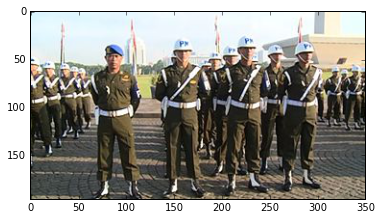

Making Inferences...
military uniform (score = 0.61369)
rifle (score = 0.24389)
assault rifle, assault gun (score = 0.07492)
pickelhaube (score = 0.01079)
half track (score = 0.00592)


In [13]:
make_inference("mp.jpg")